# Tuberculosis outbreak dynamics

In [1]:
from collections import OrderedDict, namedtuple

import numpy as np
import pandas as pd
import stan
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
%matplotlib inline


print(stan.__version__)
# stan 3.7.0

N = 1000
np.random.seed(666)

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)

3.7.0


## Load ABC posteriors

Text(0.04, 0.525, '$R_1$')

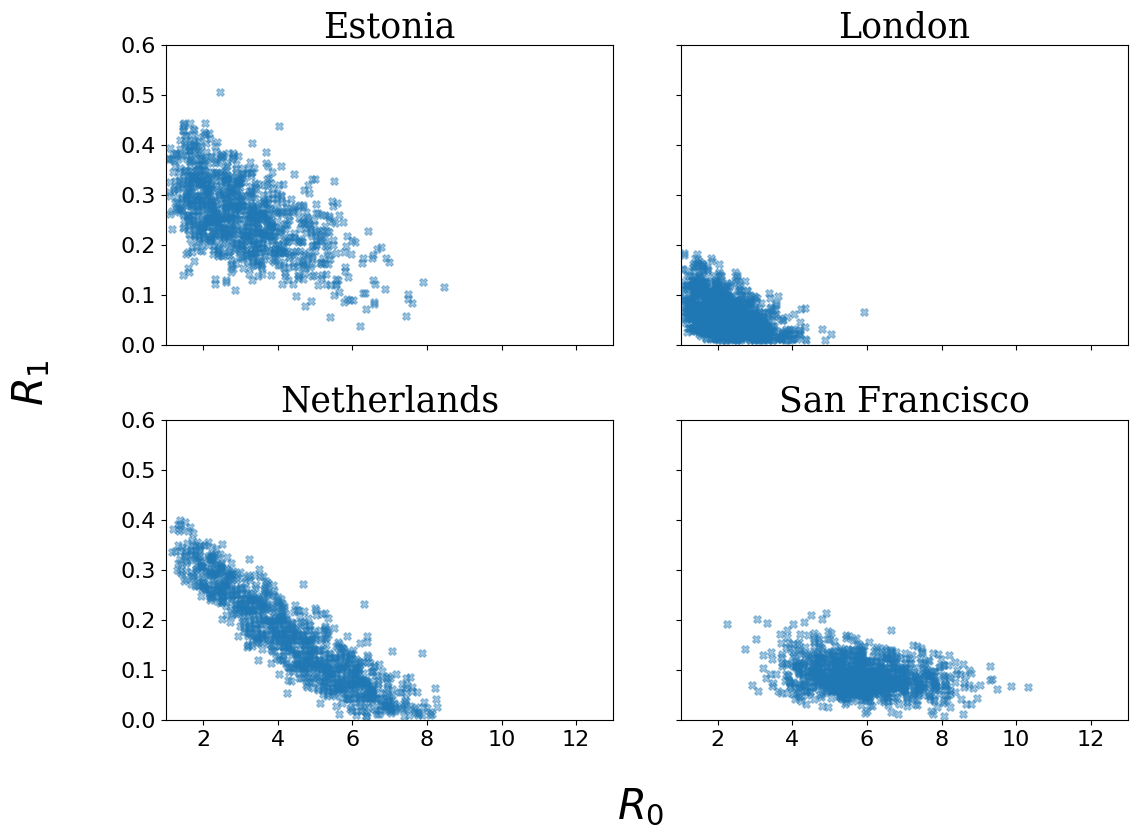

In [2]:
# use numpy==1.13.3
path = 'tb_data/'
names = ('estonia', 'london', 'netherlands', 'sfrancisco')
aliases = ('Estonia', 'London', 'Netherlands', 'San Francisco')

mus = []
Sigmas = []
samps = []


fig, axes = plt.subplots(2, 2, figsize=(13, 9), sharex='col', sharey='row')
fig.subplots_adjust(left  = 0.16, right = 0.9, bottom = 0.15, top = 0.9, wspace = 0.15, hspace = 0.25)


idx = 0
for name in names:
    R0 = np.load(path + name + '/R0.npy')
    R1 = np.load(path + name + '/R1.npy')    

    
    i = np.floor(idx/2)
    j = idx - i*2
    i = i.astype(int)
    j = j.astype(int)
        
    axes[i,j].scatter(R1, R0,s=30, marker='X', alpha=0.4)
    axes[i,j].set_xlim([1, 13])
    axes[i,j].set_ylim([0, 0.6])    
    axes[i,j].set_title(aliases[idx])
    axes[i,j].title.set_fontsize(25)
    axes[i,j].title.set_fontname('serif')

    
    idx = idx + 1
    
    samples = np.vstack((R1, R0))
    mu = np.mean(samples.T, axis=0)
    sigma = np.cov(samples)
  
    samps.append(samples)
    mus.append(mu)
    Sigmas.append(sigma)

fig.text(0.525, 0.04, r'$R_0$', ha='center', fontsize=30)
fig.text(0.04, 0.525, r'$R_1$', va='center', rotation='vertical', fontsize=30)
    


## Meta-analysis of Bayesian analyses

\begin{gather}
    \varphi_1 \sim \text{Gamma}(0.01, 0.1) \\
    \varphi_2 \sim \text{Gamma}(0.25, 0.25) \\    
    \theta_j \sim \mathcal{N}(\varphi, \Sigma_0) \quad \forall\, 1 \leq j \leq J
\end{gather}
for which the Stan specification can be written as:

In [5]:
mba_model_code = """
data {
    int<lower=0> J; // number of experiments
    int<lower=1> dim;

    // Hyperparameters for multivariate normal prior on prior on mu0
    vector[dim] m;
    cov_matrix[dim] V;    

    // Hyperparameters for the inverse-Wishart
    real nu; // degrees of freedom, has to be larger than dim-1
    cov_matrix[dim] Psi;

    // Parameters of the J observed individual posteriors over the thetas
    vector[dim] mu[J];
    cov_matrix[dim] Sigma[J]; 
}
parameters {
    // Parameters of the common prior over the thetas (collectively denoted as phi in the paper)
    vector<lower=0>[dim] mu0;
    cov_matrix[dim] Sigma0;

    // Updated posterior samples
    vector[dim] mu_upd[J];
}
model {
    mu0[1] ~ gamma(0.12, 0.36);
    mu0[2] ~ gamma(0.3, 0.05);
    Sigma0 ~ inv_wishart(nu, Psi);
    mu_upd ~ multi_normal(mu0, Sigma0);
    
    for (i in 1:J) target += multi_normal_lpdf(mu_upd[i] | mu[i], Sigma[i]);
}
"""

J = len(names)

# Specify the data block in the Stan model
dim = 2

# Mean vector for prior on mu0
m = np.array([0.1, 1])
#  Covariance matrix for prior on mu0
V = np.array([[4.0, -0.1], [-0.1, 0.01]])

# Degrees of freedom for prior on Sigma0
nu = dim + 2 # this choice makes the mean of the inverse-Wishart equal to Psi
# Prior mean for Sigma0 (see above)
Psi = np.array([[4.0, -0.1], [-0.1, 0.01]])

data = dict(J=J, dim=dim, m=m-1, V=V, nu=nu, Psi=Psi, mu=mus, Sigma=Sigmas)

import nest_asyncio
nest_asyncio.apply()

mba_model = stan.build(mba_model_code, data=data)

fit = mba_model.sample(num_chains=4, num_samples=1000)
stan_samples = fit
phi = stan_samples['mu0'].T
thetas = stan_samples['mu_upd']
S0 = stan_samples['Sigma0']

t2 = np.zeros((thetas.shape[2], thetas.shape[0], thetas.shape[1]))
for j in range(0, J):
    t2[:, j, :] = thetas[j, :, :].T
thetas = t2

sp = np.zeros((S0.shape[2], S0.shape[0], S0.shape[1]))
for j in range(0, 2):
    sp[:, j, :] = S0[j, :, :].T
S0 = sp

# SIR

def resample(weights, amount):
    choice = np.random.multinomial(amount, weights)
    N = weights.shape[0]
    new_sample_idx = []
    for i in range(N):
        if choice[i] > 0:
            for j in range(choice[i]):
                new_sample_idx.append(i)
    return new_sample_idx

approx_lprobvals = np.zeros((thetas.shape[0],))
for i in range(thetas.shape[0]):
    for j in range(J):
        approx_lprobvals[i] = approx_lprobvals[i] + scipy.stats.multivariate_normal.logpdf(thetas[i, j, :], mean=mus[j], cov=Sigmas[j])

KDE_lprobvals = np.zeros((thetas.shape[0],))
for j in range(J):
    aux_mat = thetas[:, j, :]
    kern =  scipy.stats.gaussian_kde(aux_mat.transpose())
    KDE_lprobvals = KDE_lprobvals + kern.logpdf(aux_mat.transpose())

weights = np.exp(KDE_lprobvals - approx_lprobvals)
weights = weights/np.sum(weights)

nsir = 1000
phi_sir = np.zeros( (nsir, phi.shape[1]) )
S0_sir = np.zeros( (nsir, S0.shape[1], S0.shape[2]) )
thetas_sir = np.zeros( (nsir, thetas.shape[1], thetas.shape[2]) )

sir_samp_idx = resample(weights, nsir)
for i in range(nsir):
    phi_sir[i, :] = phi[sir_samp_idx[i], :]        
    S0_sir[i, :] = S0[sir_samp_idx[i], :]    
    for j in range(J):
        thetas_sir[i, j, :] = thetas[sir_samp_idx[i], j, :]       

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_mcalqd5u/model_fiwug64v.stan', line 15, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_mcalqd5u/model_fiwug64v.stan', line 16, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_mcalqd5u/model_fiwug64v.stan', line 24, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-for

Text(0.01, 0.525, '$\\mu_2$')

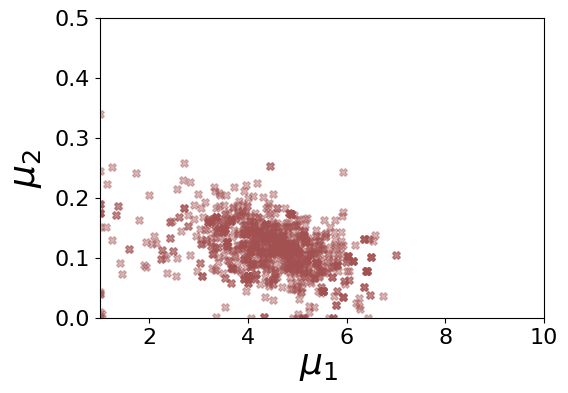

In [6]:
# more plots
fig, axes = plt.subplots(1, 1, figsize=(6, 4), sharex='col', sharey='row')
fig.subplots_adjust(left  = 0.16, right = 0.9, bottom = 0.15, top = 0.9, wspace = 0.15, hspace = 0.25)

axes.scatter(phi_sir[:,0]+1, phi_sir[:,1], marker='X',s=30, color="#A25050", alpha=0.4)
axes.set_xlim([1, 10])
axes.set_ylim([0, 0.5])   
# axes.set_xlabel(r'$\mu_1$')
# axes.set_ylabel(r'$\mu_2$')
# axes.title.set_fontsize(18)

fig.text(0.524, 0.01, r'$\mu_1$', ha='center', fontsize=26)
fig.text(0.01, 0.525, r'$\mu_2$', va='center', rotation='vertical', fontsize=26)

# fig.tight_layout()

Text(0.04, 0.525, '$R_2$')

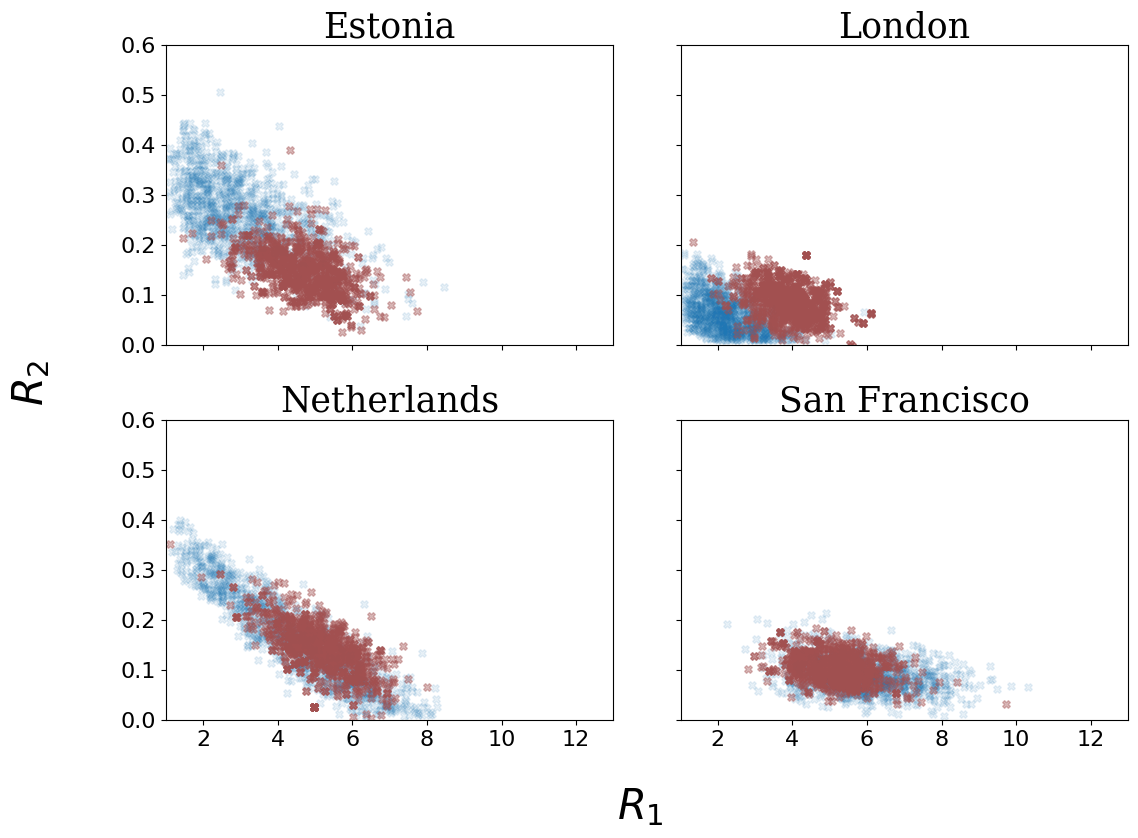

In [7]:

fig, axes = plt.subplots(2, 2, figsize=(13, 9), sharex='col', sharey='row')
fig.subplots_adjust(left  = 0.16, right = 0.9, bottom = 0.15, top = 0.9, wspace = 0.15, hspace = 0.25)

for idx in range(0, J):
    
    Rold = samps[idx]
    
    R1 = thetas[:, idx, 0]
    R0 = thetas[:, idx, 1]    

    
    R1sir = thetas_sir[:, idx, 0]
    R0sir = thetas_sir[:, idx, 1]
    
    i = np.floor(idx/2)
    j = idx - i*2
    i = i.astype(int)
    j = j.astype(int)
    
    axes[i,j].scatter(Rold[0,1:1000], Rold[1, 1:1000],  marker='X', s=30, alpha=0.1)
    axes[i,j].scatter(R1sir+1, R0sir, marker='X', s=30, color="#A25050", alpha=0.4)
    
    axes[i,j].set_xlim([1, 13])
    axes[i,j].set_ylim([0, 0.6])    
    axes[i,j].set_title(aliases[idx])
    axes[i,j].title.set_fontsize(25)
    axes[i,j].title.set_fontname('serif')      
    
fig.text(0.525, 0.04, r'$R_1$', ha='center', fontsize=30)
fig.text(0.04, 0.525, r'$R_2$', va='center', rotation='vertical', fontsize=30)